In [308]:
import pandas as pd
import zipfile
from elopy.elo import Elo
import heapq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [126]:
with zipfile.ZipFile('data/contest_results.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('extracted_files')

In [349]:
df = pd.read_csv('./extracted_files/contest_results.csv', parse_dates=['contest_date'])
df.loc[df['placing'] > 16, 'placing'] = 16

In [351]:
df_pro = df[df['organization'] == 'ifbb']
df_pro_open = df_pro[df_pro['class'] == 'open']

In [352]:
df_pro_open.head()

,contest_url,competitor_name,competitor_url,organization,contest_name,contest_date,division,class,placing,scraped_timestamp,is_loaded
17027,https://contests.npcnewsonline.com/contests/20...,paula gulman-williams,https://contests.npcnewsonline.com/contests/20...,ifbb,ifbb flex pro,2012-02-18,fitness,open,12.0,2023-11-07 03:09:15.053933 UTC,False
17028,https://contests.npcnewsonline.com/contests/20...,michele mayberry,https://contests.npcnewsonline.com/contests/20...,ifbb,ifbb flex pro,2012-02-18,fitness,open,11.0,2023-11-07 03:09:15.053471 UTC,False
17029,https://contests.npcnewsonline.com/contests/20...,sheri vucick,https://contests.npcnewsonline.com/contests/20...,ifbb,ifbb flex pro,2012-02-18,fitness,open,10.0,2023-11-07 03:09:15.05299 UTC,False
17030,https://contests.npcnewsonline.com/contests/20...,allison ethier,https://contests.npcnewsonline.com/contests/20...,ifbb,ifbb flex pro,2012-02-18,fitness,open,9.0,2023-11-07 03:09:15.05247 UTC,False
17031,https://contests.npcnewsonline.com/contests/20...,camala rodriguez,https://contests.npcnewsonline.com/contests/20...,ifbb,ifbb flex pro,2012-02-18,fitness,open,8.0,2023-11-07 03:09:15.052009 UTC,False


In [353]:
df_pro = df_pro[['competitor_name', 'placing', 'contest_name', 'contest_date', 'division', 'class']]
df_pro_open = df_pro_open[['competitor_name', 'placing', 'contest_name', 'contest_date', 'division']]

In [354]:
# every pair of competitors from the same show & division get a row
# think of this as a "match" in chess
df_merge = pd.merge(df_pro,
                    df_pro,
                    on=['contest_name', 'contest_date', 'division', 'class'],
                    how='inner',
                    suffixes=('_winner', '_loser'))

df_merge_open = pd.merge(df_pro_open,
                    df_pro_open,
                    on=['contest_name', 'contest_date', 'division'],
                    how='inner',
                    suffixes=('_winner', '_loser'))

In [355]:
df_merge.head()

,competitor_name_winner,placing_winner,contest_name,contest_date,division,class,competitor_name_loser,placing_loser
0,paula gulman-williams,12.0,ifbb flex pro,2012-02-18,fitness,open,paula gulman-williams,12.0
1,paula gulman-williams,12.0,ifbb flex pro,2012-02-18,fitness,open,michele mayberry,11.0
2,paula gulman-williams,12.0,ifbb flex pro,2012-02-18,fitness,open,sheri vucick,10.0
3,paula gulman-williams,12.0,ifbb flex pro,2012-02-18,fitness,open,allison ethier,9.0
4,paula gulman-williams,12.0,ifbb flex pro,2012-02-18,fitness,open,camala rodriguez,8.0


In [356]:
df_merge = df_merge[df_merge['placing_winner'] < df_merge['placing_loser']]
df_merge_open = df_merge_open[df_merge_open['placing_winner'] < df_merge_open['placing_loser']]

In [357]:
df_merge = df_merge[['competitor_name_winner', 'placing_winner', 'competitor_name_loser', 'placing_loser', 'contest_date', 'contest_name', 'division', 'class']]
df_merge_open = df_merge_open[['competitor_name_winner', 'placing_winner', 'competitor_name_loser', 'placing_loser', 'contest_date', 'contest_name', 'division']]

In [358]:
df_merge.head()

,competitor_name_winner,placing_winner,competitor_name_loser,placing_loser,contest_date,contest_name,division,class
12,michele mayberry,11.0,paula gulman-williams,12.0,2012-02-18,ifbb flex pro,fitness,open
24,sheri vucick,10.0,paula gulman-williams,12.0,2012-02-18,ifbb flex pro,fitness,open
25,sheri vucick,10.0,michele mayberry,11.0,2012-02-18,ifbb flex pro,fitness,open
36,allison ethier,9.0,paula gulman-williams,12.0,2012-02-18,ifbb flex pro,fitness,open
37,allison ethier,9.0,michele mayberry,11.0,2012-02-18,ifbb flex pro,fitness,open


In [296]:
df_merge[df_merge['contest_name'].str.contains('olympia')]['contest_date'].value_counts()

contest_date
2022-12-13    4302
2023-11-03    2617
2016-12-28    2206
2021-12-30    2070
2014-06-10    1973
2018-09-14    1911
2015-09-17    1848
2017-09-15    1839
2020-12-18    1782
2019-09-13    1668
2014-09-18    1184
2012-09-28    1098
2013-09-26     988
2014-06-16     803
2012-12-06     390
2012-12-02     105
Name: count, dtype: int64

In [72]:
olympia_2022 = '2022-12-13'
olympia_2023 = '2023-11-03'

In [73]:
df_2023 = df_merge[df_merge['contest_date'] < olympia_2023]
df_2023 = df_2023.sort_values(by='contest_date', ascending=True)

In [114]:
# dictionary maps competitor name to their Elo rating class
competitors = {}

In [115]:
for index, row in df_2023.iterrows():
    winner = row['competitor_name_winner']
    loser = row['competitor_name_loser']
    rank_diff = row['placing_loser'] - row['placing_winner']
    if winner not in competitors:
        competitors[winner] = Elo()
    if loser not in competitors:
        competitors[loser] = Elo()
        
    competitors[winner].play_game(competitors[loser], rank_diff)

In [116]:
bikini_olympia = df_pro[(df_pro['contest_date'] == olympia_2023)
       & (df_pro['division'] == 'bikini')]['competitor_name'].unique()

bikini_olympia = [name for name in bikini_olympia if name in competitors]

In [117]:
top_ten = []
name_rating = [(-competitors[name].elo, name) for name in bikini_olympia]
heapq.heapify(name_rating)
for i in range(10):
    print(heapq.heappop(name_rating))

(-2292.7335793102006, 'ashley kaltwasser')
(-2291.1487025403267, 'jennifer dorie')
(-2271.39177987202, 'lauralie chapados')
(-2224.7366653044833, 'elisa pecini')
(-2193.374561852178, 'maureen blanquisco')
(-2097.256944411258, 'daraja hill')
(-2080.747656703822, 'aimee leann delgado')
(-2055.120608348572, 'jourdanne lee')
(-2012.063029042556, 'romina basualdo')
(-1983.0619768109746, 'phoebe hagan')


In [118]:
competitors['ashley kaltwasser'].win_probs(competitors['jourdanne lee'])


0.8747313835059086

In [297]:
df_2022 = df_merge[df_merge['contest_date'] < olympia_2022]
df_2022 = df_2022.sort_values(by='contest_date', ascending=True)

competitors = {}

for index, row in df_2022.iterrows():
    winner = row['competitor_name_winner']
    loser = row['competitor_name_loser']
    rank_diff = row['placing_loser'] - row['placing_winner']
    if winner not in competitors:
        competitors[winner] = Elo()
    if loser not in competitors:
        competitors[loser] = Elo()
    competitors[winner].play_game(competitors[loser], rank_diff)

bikini_olympia = df_pro[(df_pro['contest_date'] == olympia_2022)
       & (df_pro['division'] == 'bikini')]['competitor_name'].unique()

bikini_olympia = [name for name in bikini_olympia if name in competitors]

In [89]:
top_ten = []
name_rating = [(-competitors[name].elo, name) for name in bikini_olympia]
heapq.heapify(name_rating)
for i in range(10):
    print(heapq.heappop(name_rating))

(-2277.931827359975, 'janet layug')
(-2257.886982595582, 'lauralie chapados')
(-2256.2749367738516, 'ashley kaltwasser')
(-2254.1088813918072, 'elisa pecini')
(-2247.0200779276165, 'jennifer dorie')
(-2088.727205079298, 'india paulino')
(-2086.3532917075217, 'maureen blanquisco')
(-2023.592664741882, 'jourdanne lee')
(-2006.6100386349601, 'ashlyn little')
(-1978.522322412744, 'romina basualdo')


In [91]:
competitors['ashley kaltwasser'].win_probs(competitors['jennifer dorie'])

0.6522448806741087

# Elo Rating Column
Here we will create a column in df_pro which includes the competitor's Elo rating leading up to that competition.

In [359]:
df_pro_open = df_pro_open.sort_values(by='contest_date', ascending=True)

In [360]:
competitors_open = {}

for contest_date in df_pro_open['contest_date'].unique():
    for index, row in df_pro_open[df_pro_open['contest_date'] == contest_date].iterrows():

        if row['competitor_name'] not in competitors_open:
            competitors_open[row['competitor_name']] = Elo()

        df_pro_open.loc[index, 'elo_rating'] = competitors_open[row['competitor_name']].elo

    for index, row in df_merge_open[df_merge_open['contest_date'] == contest_date].iterrows():
        winner = row['competitor_name_winner']
        loser = row['competitor_name_loser']
        rank_diff = row['placing_loser'] - row['placing_winner']
            
        competitors_open[winner].play_game(competitors_open[loser], rank_diff)

df_pro_open['elo_percentile'] = df_pro_open.groupby(['contest_date', 'contest_name', 'division']).elo_rating.rank(pct=True)

In [361]:
df_pro_open.tail()

,competitor_name,placing,contest_name,contest_date,division,elo_rating,elo_percentile
74414,ren yi xie,6.0,ifbb professional league china dms pro shanghai,2024-03-01,men's physique,1500.000000,0.5625
74415,xingwang yang,5.0,ifbb professional league china dms pro shanghai,2024-03-01,men's physique,1500.000000,0.5625
74416,abdullah al salem,4.0,ifbb professional league china dms pro shanghai,2024-03-01,men's physique,1504.601614,0.7500
74417,yiming wei,3.0,ifbb professional league china dms pro shanghai,2024-03-01,men's physique,1528.232828,1.0000
74419,carlos asiedu ocran,1.0,ifbb professional league china dms pro shanghai,2024-03-01,men's physique,1469.484446,0.3750


In [302]:
import matplotlib.pyplot as plt

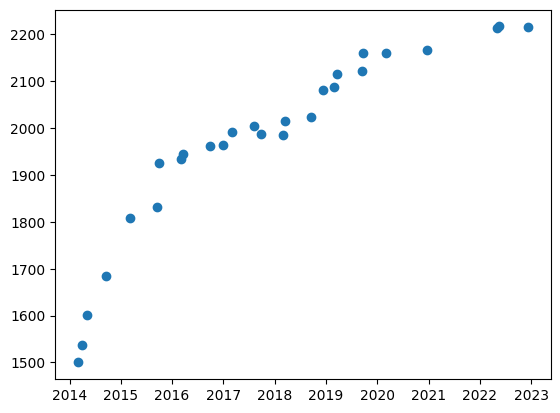

In [363]:
plt.scatter(df_pro_open[df_pro_open['competitor_name'] == 'janet layug']['contest_date'],
            df_pro_open[df_pro_open['competitor_name'] == 'janet layug']['elo_rating'])

/var/folders/0s/9k5wnkxx22l_g6lmt5xw673m0000gq/T/ipykernel_87261/1701806658.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='contest_date',
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/0s/9k5wnkxx22l_g6lmt5xw673m0000gq/T/ipykernel_87261/1701806658.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='contest_date',
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


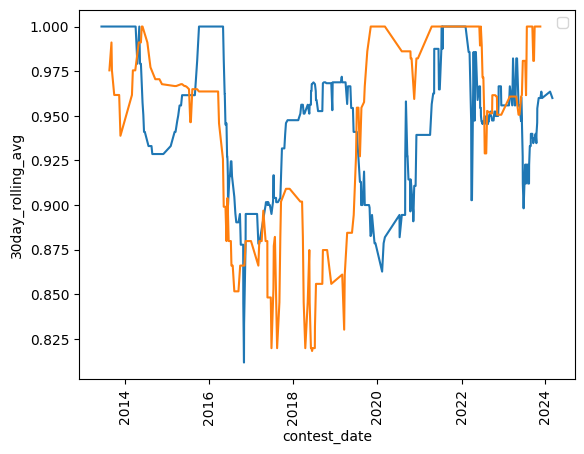

In [423]:
for idx, div in enumerate(['bikini', 'figure']):
    df_groupby = (df_pro_open[(df_pro_open['placing'] == 1) & (df_pro_open['division'] == div)]
                  .groupby(by = ['division', 'contest_date']))
    mean_elo_percentile = df_groupby['elo_percentile'].mean()
    mean_elo_percentile = mean_elo_percentile.reset_index()
    mean_elo_percentile['30day_rolling_avg'] = mean_elo_percentile['elo_percentile'].rolling(30).median()

    sns.lineplot(x='contest_date',
                y='30day_rolling_avg',
                data=mean_elo_percentile,
                palette='deep')
    plt.legend()
    plt.xticks(rotation=90);


/var/folders/0s/9k5wnkxx22l_g6lmt5xw673m0000gq/T/ipykernel_87261/3991567045.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x='contest_date',
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


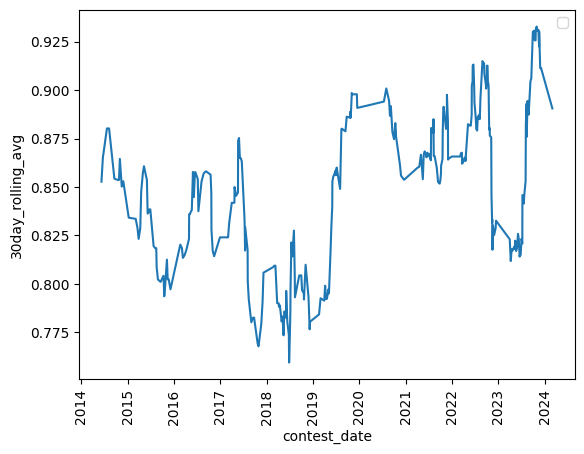

In [424]:
for idx, div in enumerate(['men\'s physique']):
    df_groupby = (df_pro_open[(df_pro_open['placing'] == 1) & (df_pro_open['division'] == div)]
                  .groupby(by = ['division', 'contest_date']))
    mean_elo_percentile = df_groupby['elo_percentile'].mean()
    mean_elo_percentile = mean_elo_percentile.reset_index()
    mean_elo_percentile['30day_rolling_avg'] = mean_elo_percentile['elo_percentile'].rolling(30).mean()

    sns.lineplot(x='contest_date',
                y='30day_rolling_avg',
                data=mean_elo_percentile,
                palette='deep')
    plt.legend()
    plt.xticks(rotation=90);

In [420]:
df_pro_open['division'].value_counts()

division
bikini                    9273
men's physique            7864
figure                    5465
women's physique          3913
men's classic physique    3391
men's bodybuilding        2779
212                       2042
fitness                   1337
women's bodybuilding      1134
wellness                   921
women's wellness           188
Name: count, dtype: int64

In [381]:
df_pro_open['elo_rank'] = df_pro_open.groupby(['contest_date', 'contest_name', 'division']).elo_rating.rank()
df_pro_open.loc[df_pro_open['elo_rank'] > 16, 'elo_rank'] = 16

In [373]:
df_pro_open.head()

,competitor_name,placing,contest_name,contest_date,division,elo_rating,elo_percentile,elo_rank
17027,paula gulman-williams,12.0,ifbb flex pro,2012-02-18,fitness,1500.0,0.541667,6.5
17055,lionel beyeke,1.0,ifbb flex pro,2012-02-18,men's bodybuilding,1500.0,0.529412,9.0
17054,ben pakulski,2.0,ifbb flex pro,2012-02-18,men's bodybuilding,1500.0,0.529412,9.0
17053,fouad abiad,3.0,ifbb flex pro,2012-02-18,men's bodybuilding,1500.0,0.529412,9.0
17052,shawn rhoden,4.0,ifbb flex pro,2012-02-18,men's bodybuilding,1500.0,0.529412,9.0


<Axes: >

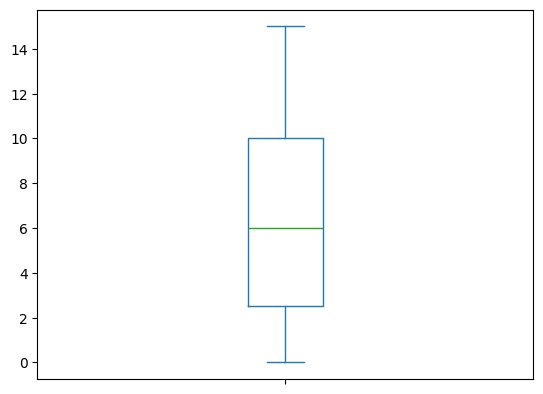

In [376]:
abs(df_pro_open['placing'] - df_pro_open['elo_rank']).plot.box()

In [371]:
df_pro_open['elo_rank'].value_counts()

elo_rank
1.0     2150
2.0     2104
3.0     2018
4.0     1905
5.0     1838
        ... 
60.0       1
58.0       1
62.0       1
61.0       1
59.0       1
Name: count, Length: 86, dtype: int64